# Excerise - Logistic Regression and Classification Measures
In this exercise you will explore how hard it is to find the best balance between TPR and FPR. 

Next, you will implement a logistic regression classifier using gradient decent.

We will then turn to applying multi-class classifiers over the well known MNIST digits database, and analyse the results using a confusion matrix.

## Balancing TPR and FPR and interpretability of a classifier results given inbalance between classes
After your yearly checkup, the doctor has bad news and good news. The bad news is that you tested positive for a serious disease, and that the test is 99% accurate (i.e. the probability of testing positive given that you have the disease is 0.99, as is the probability of testing negative given that you don’t have the disease). The good news is that this is a rare disease, striking only 1 in 10,000 people. 

1. What is the accuracy of always predicting a patient is healthy? Would that be a good strategy?

2. What are the TPR and FPR of the chosen classifier in this case? Giving that there is a tradeoff between the two --- is it a good point on the ROC curve?

3. Why is it good news that the disease is rare? What are the chances that you actually have the disease?

4. Taking into account the previous answers, would you say the designer of the classifier made a good choice in this case?



#### Answer 1
The accuracy of always predicting a patient is healthy would be 99.99%.
However using this statistic as a classifier won't be a good strategy, as we would never identify any patient who is actually sick.
To be more specific - this model will have 0 precision and 0 recall, as there will be no true positives, i.e. no sick patient identified as such.

#### Answer 2

$TPR = Recall = \frac{TP}{TP + FN} = 0$ 
(TP = 0)

$FPR = \frac{FP}{FP + TN} = 0$
(FP = 0)

In this case, the classifying threshold will be 1.0, as both $TPR = FPR = 0$.

It is not a good location on the ROC curve, as we didn't identify any unhealthy patients.

#### Answer 3
The fact that the disease is rare means that
$P($Having the disease | Testing +$)$ is low.

We know that $P($Testing + | Having the disease$)\,=\,0.99$, 

however it is not equal to $P($Having the disease | Testing +$)$.

In our case $P($Having the disease | Testing +$)\,\approx\,0.009$


#### Answer 4
Seems that the classifier choise wasn't a good idea in this case - even though the disease is rare, it doesn't mean we DON'T NEED to identify those patients who have the disease - which of course we won't identify given the used classifier.

## Implementing Logistic Regression Model
Recall the loss function of the binary (Univariate) Logistic Regression model

$$ J(\beta)=-\frac{1}{m}\sum_{i=1}^{m}\left(y^{(i)}\log(h_\beta(x^{(i)}))+(1-y^{(i)})\log(1-h_\beta(x^{(i)}))\right) $$

and the gradient decent update rule is given by

$$ \beta_j^t := \beta_j^{t-1}-\mu\frac{\partial}{\partial \beta_j}J(\beta)
$$

1. Write the explicit (and rather simple) update rule for a gradient decent solver of the Logistic Regression model.
2. Implement a LogisticRegression class with `fit`, `predict`, and `score` functions, and the constructor of the class should have the following parameters (feel free to add methods and parameters as you see fit):
  * `method`: either `GD` or `SGD`, indiacting whether to use a regular gradient decent, or an [iterative stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Iterative_method) respectively.
  * `learning_rate`: the learning rate to be used
  * `num_iterations`: number of iterations for the gradient decent algorithms (**note** that for stochastic gradient decent, each iteration is interpreted in that aspect as an epoch of going over all the samples, as it is computationaly similar to a single iteration of regular gradient decent)
  * `track_loss`: a boolean stating if to track the loss of the model for each iteration during training; if `True` the model will have a `loss` vector with the loss that was claculated for each of the iterations.
3. Use the provided code to load the Iris dataset as a toy example, on which we will compare the results of the two logistic regression solvers. Run both solvers (GD and SGD) for 1000 iterations, using a learning rate of 0.1, and compare the learning curve by plotting the loss during training. Describe the results, and plot the decision boundary for each of the models. What would you see if you plot the loss after each parameters update (for each sample in every epoch)?
 
 
For simplicity, do not use regularization, and we will not try to find the best learning rate --- however, you are more than welcome to play with those on your own.


#### Answer 1
Deriving $\frac{\partial J(\beta)}{\partial \beta_j} $ will be:

$\frac{\partial J(\beta)}{\partial \beta_j} = \dfrac{1}{m} \sum_{i=1}^{m} (h_\beta(x^{(i)}) - y^{(i)}) x_j^{(i)}$

Thus the update rule will be:

$\beta_j^t := \beta_j^{t-1} - \mu \dfrac{1}{m} \sum_{i=1}^{m} (h_{\beta^{t-1}}(x^{(i)}) - y^{(i)}) x_j^{(i)}$

#### Answer 2

In [5]:
import numpy as np
from sklearn.utils import shuffle

from IPython.display import clear_output

class LogisticRegression:
    """
    method - either GD or SGD
    learning_rate
    num_iterations
    track_loss - whether to track the loss during fit operation
    tolerance - relevant for SGD - default = 1e-5 
    """
    def __init__(self,
                 method,
                 learning_rate,
                 num_iterations,
                 track_loss,
                 tolerance=1e-5,
                 plot_loss_every_epoch=False):
        self.method = method
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.track_loss = track_loss
        self.loss = [] # will contain the loss, if track_loss is True
        self.weights = np.array([])
        self.tolerance = tolerance
        self.plot_loss_every_epoch = plot_loss_every_epoch
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __loss(self, X, y):
        z = np.dot(X, self.weights)
        h = self.__sigmoid(z)
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def __stochastic_gradient_descent(self, X, y):
        n_samples = X.shape[0]
        # add bias column to X
        intercept = np.ones((n_samples, 1))
        X_with_intercept = np.concatenate((intercept, X), axis=1)
        n_features = X_with_intercept.shape[1] 
        # initialize weights
        self.weights = np.zeros(n_features)
        
        for i in range(self.num_iterations):
            X_i, y_i = shuffle(X_with_intercept, y)
            for j in range(n_samples):
                #self.weights @ X_i[j,:].T
                z = np.dot(X_i[j,:], self.weights)
                h = self.__sigmoid(z) 
                gradient = (h - y_i[j]) * X_i[j,:] / n_samples
                self.weights -= self.learning_rate * gradient
            if (self.track_loss):
                current_loss = self.__loss(X_with_intercept, y)
                self.loss.append(current_loss)
                if(self.plot_loss_every_epoch):
                    self.__on_epoch_end(i+1)
                    #print(f'loss: {current_loss} \t')
    
    def __gradient_descent(self, X, y):
        # add bias column to X
        n_samples = X.shape[0]
        intercept = np.ones((n_samples, 1))
        X_with_intercept = np.concatenate((intercept, X), axis=1)
        n_features = X_with_intercept.shape[1]
        # initialize weights
        self.weights = np.zeros(n_features)
        
        for i in range(self.num_iterations):
            z = np.dot(X_with_intercept, self.weights)
            h = self.__sigmoid(z)
            gradient = np.dot(X_with_intercept.T, (h - y)) / n_samples
            self.weights -= self.learning_rate * gradient
            
            if (self.track_loss):
                current_loss = self.__loss(X_with_intercept, y)
                self.loss.append(current_loss)
                if(self.plot_loss_every_epoch):
                    self.__on_epoch_end(i+1)
                    #print(f'loss: {current_loss} \t')
    
    def __on_epoch_end(self, epoch):
        clear_output(wait=True)
        plt.plot(list(range(0, epoch)), self.loss, label="loss")
        plt.legend()
        plt.show();
    
    def fit(self, X, y):
        if self.method == "GD":
            self.__gradient_descent(X, y)
        elif self.method == "SGD":
            self.__stochastic_gradient_descent(X, y)
    
    def predict_prob(self, X):
        n_samples = X.shape[0]
        # add bias column to X
        intercept = np.ones((n_samples, 1))
        X_with_intercept = np.concatenate((intercept, X), axis=1)
        return self.__sigmoid(np.dot(X_with_intercept, self.weights))
    
    def predict(self, X, threshold=0.5):
        # binary classification:
        # result above 0.5 - rounding to 1
        # result below 0.5 - rounding to 0
        return self.predict_prob(X) >= threshold

    def score(self, X, y):
        y_pred = self.predict(X)
        score = float(sum(y_pred == y))/ float(len(y))
        return score

#### Answer 3

Below is the code for loading the iris dataset and plotting the data with the models decision boundary.

In [6]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, :2]
y = (iris.target != 0) * 1

In [7]:
import matplotlib.pyplot as plt

def plot_samples(X, y, model_method, gd_model=None, sgd_model=None, model_pred_color="black", plot_idx=1):
    plt.subplot(2, 2, plot_idx)
    plt.title('Method: %s' % model_method)
    
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
  
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    if gd_model is not None:
        probs = gd_model.predict_prob(grid).reshape(xx1.shape)
        plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors=model_pred_color, label='GD');
    if sgd_model is not None:
        probs = sgd_model.predict_prob(grid).reshape(xx1.shape)
        plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors=model_pred_color, label='SGD');
    plt.legend()

/Users/tzipi/envs/ydata/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'label'
  app.launch_new_instance()


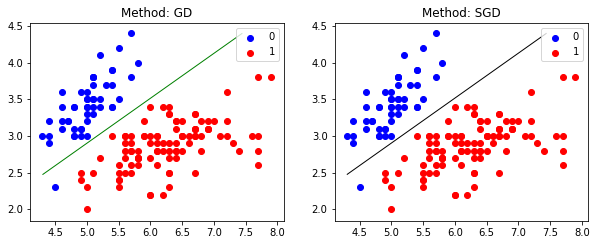

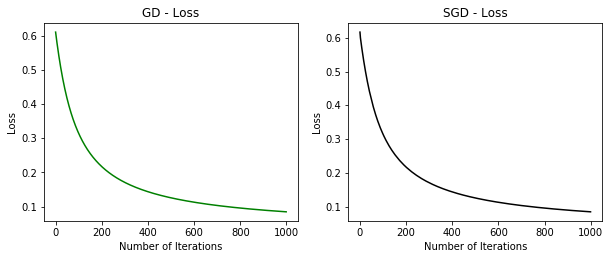

In [8]:
num_iterations = 1000
learning_rate = 0.1

gd_model = LogisticRegression(method="GD",\
                              learning_rate=learning_rate,\
                              num_iterations=num_iterations,\
                              track_loss=True)
gd_model.fit(X, y)
#plot_samples(X, y, gd_model)
#gd_model.score(X, y)

sgd_model = LogisticRegression(method="SGD",\
                              learning_rate=learning_rate,\
                              num_iterations=num_iterations,\
                              track_loss=True)
sgd_model.fit(X, y)
#plot_samples(X, y, sgd_model=sgd_model)
#gd_model.score(X, y)

plt.figure(figsize=(10, 8))
plot_samples(X, y, "GD", gd_model, model_pred_color="green", plot_idx=1)
plot_samples(X, y, "SGD", sgd_model, model_pred_color="black", plot_idx=2)
plt.show()

# plotting the loss
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("GD - Loss")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.plot(range(num_iterations), gd_model.loss, 'green');

plt.subplot(2, 2, 2)
plt.title("SGD - Loss")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.plot(range(num_iterations), sgd_model.loss, 'black');

### Describe the results

The results are similar.

In [9]:
def plot_decision_boundary(X, y, model_method, model, plot_idx=1, plot_probs=False):
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = None
    if (plot_probs):
        Z = model.predict_prob(np.c_[xx.ravel(), yy.ravel()])
    else: 
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.subplot(4, 2, plot_idx)
    plt.title("Decision boundary for %s" % model_method)
    plt.contourf(xx, yy, Z, cmap='Paired_r', alpha=0.25)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.7)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired_r', edgecolors='k');

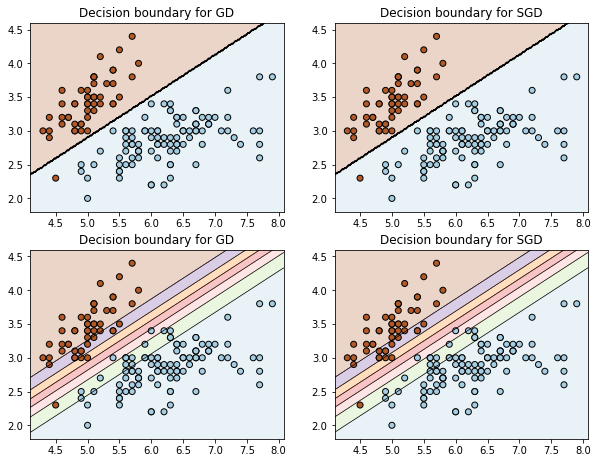

In [10]:
plt.figure(figsize=(10, 16))
plot_decision_boundary(X, y, "GD", gd_model, plot_idx=1)
plot_decision_boundary(X, y, "SGD", sgd_model, plot_idx=2)


plot_decision_boundary(X, y, "GD", gd_model, plot_idx=3, plot_probs=True)
plot_decision_boundary(X, y, "SGD", sgd_model, plot_idx=4, plot_probs=True)

### What would you see if you plot the loss after each parameters update (for each sample in every epoch)?

Well, let's take a look:

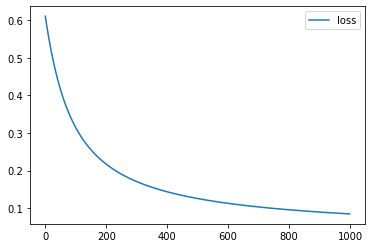

In [13]:
# GD
num_iterations = 1000
learning_rate = 0.1

gd_model = LogisticRegression(method="GD",\
                              learning_rate=learning_rate,\
                              num_iterations=num_iterations,\
                              track_loss=True,
                              plot_loss_every_epoch=True)
gd_model.fit(X, y)

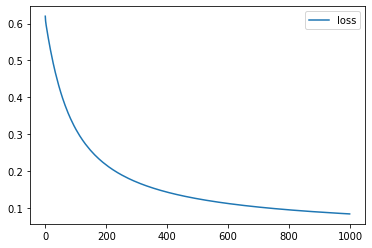

In [16]:
# SGD
num_iterations = 1000
learning_rate = 0.1

sgd_model = LogisticRegression(method="SGD",\
                              learning_rate=learning_rate,\
                              num_iterations=num_iterations,\
                              track_loss=True,
                              plot_loss_every_epoch=True)
sgd_model.fit(X, y)

## Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Multivariate Logistic Regression (a discriminative model). 

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, each image faltten to create a 1D array with 784 elements.

### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
>```mnist = sklearn.datasets.fetch_mldata('MNIST original')```

to fetch the original data. You may set the `data_home` to where you wish to download your data for caching. Each image is already transformed into a 1D integer array $x\in [0,255]^{784}$, and the corresponding label is an integer $y\in [0,9]$.

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.

---
**Note:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this exercise. Feel free to test the proformance of the algorithms below on the preprocessed data as well.


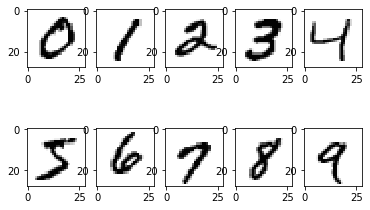

In [17]:
# your code
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', data_home='datasets/')

X, y = (mnist.data, mnist.target)

fig, ax = plt.subplots(2,5)
ax = ax.flatten()
for i in range(10):
    im_idx = np.argwhere(y == str(i))[0]
    plottable_image = np.reshape(X[im_idx], (28, 28))
    ax[i].imshow(plottable_image, cmap='gray_r')

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test \
            = train_test_split(X, y, test_size=(1/7))

### Multivariate Logistic Regression
We will now apply the Multivariate Logistic Regression model discriminative model for this problem. We will use a prepared implementation of the model, so you won't need to implement it.

In this part we will keep the pixel values in grayscale, and assume the probability of each image being classified as one of the 10 digit classes, matches some multivariate logistic function.

#### Question 1
Run a Multivariate Logitic Regression classifier on the training data and apply predictions on the test data. Use the [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation, and set the `solver` to be `'lbfgs'`, and  `multi_class` to `'multinomial'` (leave all other parameters in their default value).

1. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

2. Show some test images which were missclassified (classified incorrectly). Choose one such sample, and output the probability estimates for all classes (use the `predict_proba` function). Describe the results.

Note that here we cannot "generate" examples from the model.

#### Answer 1
Put you answer here...

/Users/tzipi/envs/ydata/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


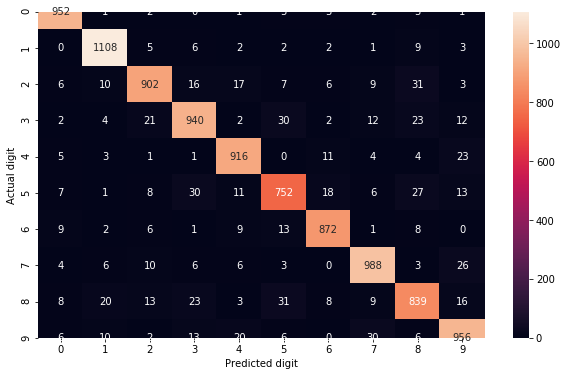

Total accuray is 0.9225


In [19]:
# code goes here
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sn

@ignore_warnings(category=ConvergenceWarning)
def fit_logistic_regression_to_mnist(lr, X_train, y_train, X_test, y_test):
    lr.fit(X_train, y_train)
    y_test_pred = lr.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10,6))
    ax = sn.heatmap(confusion_mat, annot=True,fmt='g')
    ax.set(xlabel='Predicted digit', ylabel='Actual digit')
    plt.show()

    print('Total accuray is {}'.format((y_test_pred == y_test).mean()))
    return y_test_pred
    
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
y_test_pred = fit_logistic_regression_to_mnist(lr, X_train, y_train, X_test, y_test)

We can see that some digits are easier to classify correctly than others
e.g. 0 is easier than 5

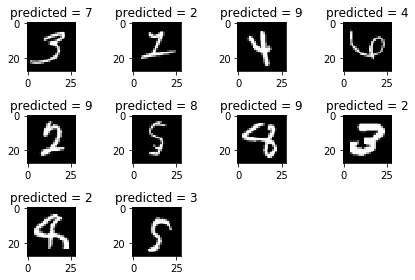

In [20]:
mislabeled_indices = np.where(y_test_pred != y_test)[0]

i=0
for idx in mislabeled_indices[:10]:
    pixels = X_test[idx,:].reshape((28, 28))
    plt.subplot(3, 4, i + 1)
    plt.title('predicted = %s' % y_test_pred[idx])
    plt.imshow(pixels, cmap='gray')
    i+=1
plt.tight_layout()
plt.show()

In [21]:
print('probs for missclassified digit above:')
for idx in mislabeled_indices[:10]:
    probs = lr.predict_proba([X_test[idx,:]])
    print(list(map(lambda x: "%.5f" % x, probs[0])))

probs for missclassified digit above:
['0.00004', '0.00008', '0.00007', '0.21334', '0.00001', '0.00293', '0.00000', '0.71767', '0.00044', '0.06542']
['0.00002', '0.00015', '0.87724', '0.10810', '0.00000', '0.00213', '0.00012', '0.00179', '0.00855', '0.00190']
['0.00000', '0.00027', '0.00003', '0.00959', '0.40574', '0.00096', '0.00013', '0.00111', '0.03553', '0.54665']
['0.00004', '0.00000', '0.00154', '0.00031', '0.57917', '0.00000', '0.00512', '0.41128', '0.00120', '0.00134']
['0.04492', '0.00001', '0.17121', '0.02749', '0.00042', '0.03603', '0.00002', '0.17415', '0.04378', '0.50197']
['0.00050', '0.00004', '0.07510', '0.16960', '0.00615', '0.21829', '0.05260', '0.00010', '0.44292', '0.03469']
['0.00006', '0.00000', '0.00010', '0.23239', '0.26773', '0.03088', '0.00000', '0.01531', '0.02077', '0.43276']
['0.00003', '0.00000', '0.99943', '0.00053', '0.00000', '0.00000', '0.00000', '0.00000', '0.00001', '0.00000']
['0.00002', '0.00000', '0.38690', '0.00002', '0.00001', '0.30067', '0.0004

#### Question 2
Comparing two methods for solving multiclass classification problems: one-vs-rest (OvR), and multinomial.

1. Discuss the results, and explain the plots in [Plot multinomial and One-vs-Rest Logistic Regression](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html).

2. Create another Logistic Regression classifier, setting now `multi_class` to `'ovr'` (instead of `multinomial`). Leave all other parameters the same. Compare the accuracy of this model with the previous one model. 




#### Answer 2
Put you answer here...

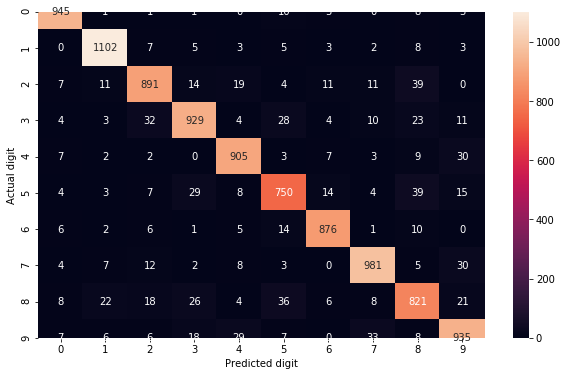

Total accuray is 0.9135


In [22]:
ovr_lr = LogisticRegression(solver='lbfgs', multi_class='ovr')
y_test_pred = fit_logistic_regression_to_mnist(ovr_lr, X_train, y_train, X_test, y_test)


We can see that for most digits, multivariate has better accuracy.

We also see that for classes that multivariate did very good on (0 and 6),
OVR does slightly better. 

Perhaps because if a class is highly distuinguishable from the rest,
there's no point in "confusing" the classifier with information on all other classes.


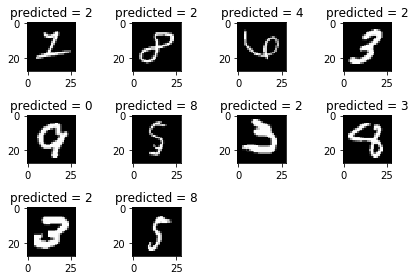

probs for missclassified digit above:
['0.00002', '0.00015', '0.87724', '0.10810', '0.00000', '0.00213', '0.00012', '0.00179', '0.00855', '0.00190']
['0.00448', '0.00016', '0.21245', '0.00304', '0.00001', '0.01692', '0.00001', '0.00011', '0.72717', '0.03565']
['0.00004', '0.00000', '0.00154', '0.00031', '0.57917', '0.00000', '0.00512', '0.41128', '0.00120', '0.00134']
['0.00001', '0.00019', '0.18220', '0.79833', '0.00000', '0.00951', '0.00000', '0.00000', '0.00966', '0.00010']
['0.01903', '0.00000', '0.00000', '0.00000', '0.00676', '0.00000', '0.00000', '0.02038', '0.00152', '0.95230']
['0.00050', '0.00004', '0.07510', '0.16960', '0.00615', '0.21829', '0.05260', '0.00010', '0.44292', '0.03469']
['0.00040', '0.00000', '0.32589', '0.67368', '0.00000', '0.00002', '0.00000', '0.00000', '0.00000', '0.00000']
['0.00006', '0.00000', '0.00010', '0.23239', '0.26773', '0.03088', '0.00000', '0.01531', '0.02077', '0.43276']
['0.00003', '0.00000', '0.99943', '0.00053', '0.00000', '0.00000', '0.0000

In [23]:
mislabeled_indices = np.where(y_test_pred != y_test)[0]

i=0
for idx in mislabeled_indices[:10]:
    pixels = X_test[idx,:].reshape((28, 28))
    plt.subplot(3, 4, i + 1)
    plt.title('predicted = %s' % y_test_pred[idx])
    plt.imshow(pixels, cmap='gray')
    i+=1
plt.tight_layout()
plt.show()

print('probs for missclassified digit above:')
for idx in mislabeled_indices[:10]:
    probs = lr.predict_proba([X_test[idx,:]])
    print(list(map(lambda x: "%.5f" % x, probs[0])))

Interesting to see that the rogue 5 that multivariate tagged as 3 was tagged by ovr as 8

Also, OVR gave this 5 an almost 0 probability to be 5
